# FastChat
用于训练、部署和评估基于大型语言模型的聊天机器人的开放平台  
体验地址：https://chat.lmsys.org/  
FastChat核心特性包括：
- 提供了SOTA模型（比如Vicuna，FastChat-T5）的模型权重，训练代码，评估代码；
- 分布式多模型部署系统，自带Web UI和OpenAI兼容的RESTful APIs。

## 安装
方法一：
```
pip3 install "fschat[model_worker,webui]"
```
方法二：
```
git clone https://github.com/lm-sys/FastChat.git
cd FastChat


brew install rust cmake  # mac需要安装cmake



pip3 install --upgrade pip  # enable PEP 660 support
pip3 install -e ".[model_worker,webui]"
```

## 使用
```
python3 -m fastchat.serve.cli --model-path lmsys/longchat-7b-32k-v1.5
```
可以使用 --style rich 来启用富文本输出，提高某些非 ASCII 内容的文本流传输质量。在某些终端上可能无法正常工作

### 支持的模型
https://github.com/lm-sys/FastChat/blob/main/docs/model_support.md
### 单GPU
```
python3 -m fastchat.serve.cli --model-path lmsys/vicuna-7b-v1.5
```
如果显存不够，可以参考：https://github.com/lm-sys/FastChat#not-enough-memory
### 多GPU
```
python3 -m fastchat.serve.cli --model-path lmsys/vicuna-7b-v1.5 --num-gpus 2
```
有时候”auto“策略在huggingface/transformers不能在多GPU间平衡，因此最好增加参数”--max-gpu-memory“，该参数可以指定每个gpu用于存储模型权重的最大内存。这允许它为激活分配更多的内存，因此可以使用更长的上下文长度或更大的批处理大小。最好的命令是：
```
python3 -m fastchat.serve.cli --model-path lmsys/vicuna-7b-v1.5 --num-gpus 2 --max-gpu-memory 8GiB
```
### 仅cpu
```
python3 -m fastchat.serve.cli --model-path lmsys/vicuna-7b-v1.5 --device cpu
```
如果使用AVX512_BF16/AMX加速CPU推理
```
CPU_ISA=amx python3 -m fastchat.serve.cli --model-path lmsys/vicuna-7b-v1.5 --device cpu
```
### Metal Backend(带苹果Silicon 或AMD GPU的Mac电脑)
```
python3 -m fastchat.serve.cli --model-path lmsys/vicuna-7b-v1.5 --device mps --load-8bit
```
参数”--device mps“在torch>2.0情况下，可以加速mac GPU运算；参数”--load-8bit“可以量化为int8。Vicuna-7B在32GB内存的M1 Mac电脑 上推理时，每秒会生成1 - 2个词。
### Intel XPU（Intel Data Center和Arc A-Series GPU）
安装Intel Extension for PyTorch（https://intel.github.io/intel-extension-for-pytorch/xpu/latest/tutorials/installation.html）。设置OneAPI环境变量：
```
source /opt/intel/oneapi/setvars.sh
```
使用 --device xpu 启用XPU/GPU加速。
```
python3 -m fastchat.serve.cli --model-path lmsys/vicuna-7b-v1.3 --device xpu
```
Vicuna-7B 可以在Intel Arc A770 16GB上运行。
### 显存不足
对于显存不够的情况，可以参考量化或者offload策略来部分解决，比如在命令行加入参数”--load-8bit“或者”--cpu-offloading“
```
python3 -m fastchat.serve.cli --model-path lmsys/vicuna-7b-v1.5 --load-8bit
```

### WEB GUI
使用web UI提供服务，需要三个主要组件：与用户接口的web服务器、托管一个或多个模型的模型worker，以及协调web服务器和模型worker的controller。更多信息可以参考：https://github.com/lm-sys/FastChat/blob/main/docs/server_arch.md

启动controller
```
python3 -m fastchat.serve.controller
```
启动模型worker
```
python3 -m fastchat.serve.model_worker --model-path lmsys/vicuna-7b-v1.5
```
启动成功后，会看到"Uvicorn running on ..."，也可以通过如下命令来测试模型worker是否正确连接controller
```
python3 -m fastchat.serve.test_message --model-name vicuna-7b-v1.5
```
启动Gradio Web服务器
```
python3 -m fastchat.serve.gradio_web_server
```

## FastChat模型评估
FastChat使用多轮开放式问题来评估模型。为了实现评估过程的自动化，建议采用像GPT-4这样的强大LLM评估模型的回复（https://github.com/lm-sys/FastChat/blob/main/fastchat/llm_judge）。

具体步骤如下：
1. 从不同的模型生成回答：使用 qa_baseline_gpt35.py 获取ChatGPT的回答，或者指定模型检查点并运行 get_model_answer.py 获取 Vicuna 和其他模型的回答；
2. 使用 GPT-4 生成评论：使用 GPT-4 自动生成评论。如果您无法使用 GPT-4 API，则可以手动执行此步骤；
3. 生成可视化数据：运行 generate_webpage_data_from_table.py 生成静态网站的数据，以便您可以可视化评估数据；
4. 可视化数据：在 webpage 目录下提供一个静态网站。您可以使用 python3 -m http.server 在本地提供网站服务。

数据格式和贡献  
采用JSON Lines 编码的数据格式进行评估，该格式包括有关模型、提示、评论者、问题、回答和评论的信息。

## 模型微调
1. 数据
Vicuna 是通过使用从 ShareGPT.com 上收集的约 7 万个用户共享对话使用 LLaMA 基础模型进行微调而创建的，使用了公共的 API。为了确保数据质量，将 HTML 转换回 Markdown，并过滤掉一些不适当或低质量的样本。此外，将较长的对话分割成适合模型最大上下文长度的较小段落（https://github.com/lm-sys/FastChat/blob/main/docs/commands/data_cleaning.md）。

目前可能不会发布 ShareGPT 数据集，如果想尝试微调代码，可以使用 dummy_conversation.json（https://github.com/lm-sys/FastChat/blob/main/data/dummy_conversation.json）中的一些虚拟对话来运行它，可以按照相同的格式插入自己的数据。
2. 代码和参数
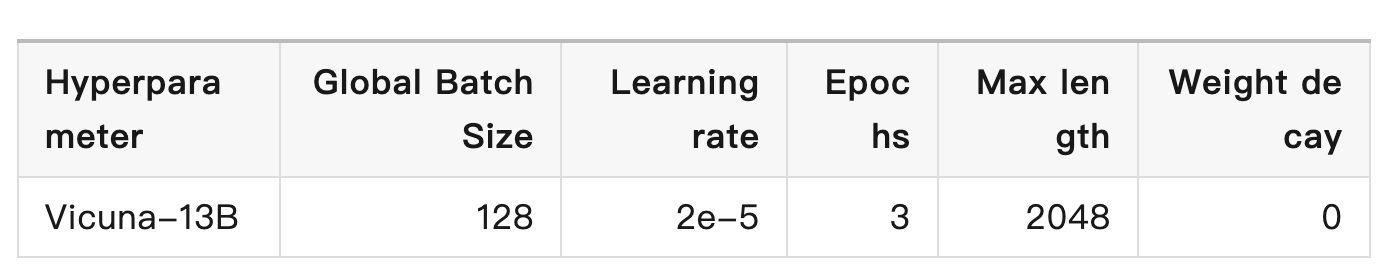
3. 使用本地GPU微调Vicuna-7B模型
```
pip3 install -e ".[train]"
```
使用以下命令使用 4 个 A100 (40GB) 对 Vicuna-7B 进行训练
```
torchrun --nproc_per_node=4 --master_port=20001 fastchat/train/train_mem.py \
    --model_name_or_path meta-llama/Llama-2-7b-hf \
    --data_path data/dummy_conversation.json \
    --bf16 True \
    --output_dir output_vicuna \
    --num_train_epochs 3 \
    --per_device_train_batch_size 2 \
    --per_device_eval_batch_size 2 \
    --gradient_accumulation_steps 16 \
    --evaluation_strategy "no" \
    --save_strategy "steps" \
    --save_steps 1200 \
    --save_total_limit 10 \
    --learning_rate 2e-5 \
    --weight_decay 0. \
    --warmup_ratio 0.03 \
    --lr_scheduler_type "cosine" \
    --logging_steps 1 \
    --fsdp "full_shard auto_wrap" \
    --fsdp_transformer_layer_cls_to_wrap 'LlamaDecoderLayer' \
    --tf32 True \
    --model_max_length 2048 \
    --gradient_checkpointing True \
    --lazy_preprocess True
```